Data fields description:
- Voltage_measured: Battery terminal voltage (Volts)
- Current_measured: Battery output current (Amps)
- Temperature_measured: Battery temperature (degree C)
- Current_charge: Current measured at load (Amps)
- Voltage_charge: Voltage measured at load (Volts)
- Time: Time vector for the cycle (secs)
- Capacity: Battery capacity (Ahr) for discharge till 2.7V
- time: the date and time of the start of the cycle

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# Load the data
data = pd.read_csv('discharge.csv')

In [3]:
data.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Battery
0,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,discharge,24,2008.0,B0005
1,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,discharge,24,2008.0,B0005
2,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,discharge,24,2008.0,B0005
3,3.920058,-2.013007,24.909816,1.9982,2.991,90.094,1.856487,1,discharge,24,2008.0,B0005
4,3.907904,-2.014400,25.105884,1.9982,2.977,108.281,1.856487,1,discharge,24,2008.0,B0005


In [4]:
data.isnull().count()

Voltage_measured        169766
Current_measured        169766
Temperature_measured    169766
Current_charge          169766
Voltage_charge          169766
Time                    169766
Capacity                169766
id_cycle                169766
type                    169766
ambient_temperature     169766
time                    169766
Battery                 169766
dtype: int64

In [5]:
print(data.describe())

       Voltage_measured  Current_measured  Temperature_measured  \
count     169766.000000     169766.000000         169766.000000   
mean           3.503756         -2.004652             31.985477   
std            0.245871          0.009801              3.780617   
min            1.737030         -2.029098             22.372620   
25%            3.389014         -2.011621             29.419671   
50%            3.507333         -2.009471             31.931205   
75%            3.665754         -1.991235             34.756413   
max            4.035025         -1.974808             42.083729   

       Current_charge  Voltage_charge           Time       Capacity  \
count   169766.000000   169766.000000  169766.000000  169766.000000   
mean         1.998999        2.573131    1446.758949       1.584585   
std          0.000704        0.238604     850.462795       0.189489   
min          1.998000        0.890000      19.468000       1.153818   
25%          1.998200        2.458000    

<ipython-input-6-9fa67090a602>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True)


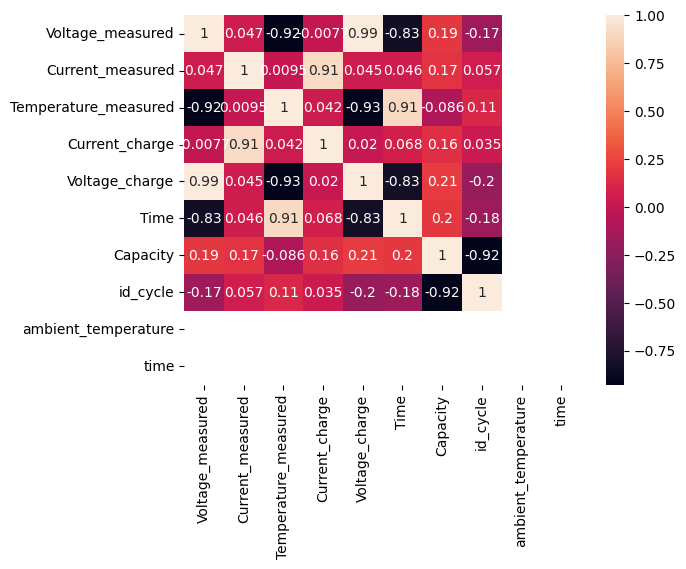

In [6]:
sns.heatmap(data.corr(), annot=True)
plt.show()

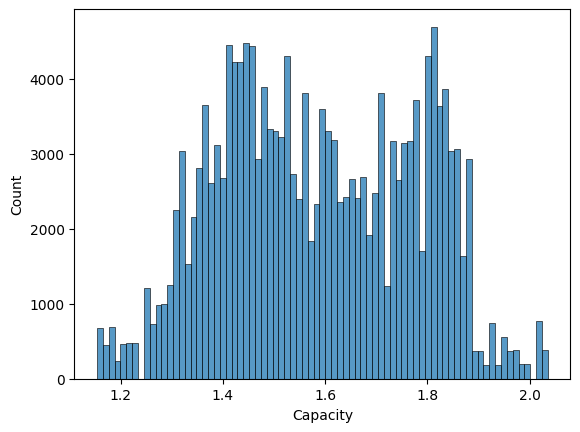

In [7]:
# Distribution of the capacity variable
sns.histplot(data=data, x="Capacity")
plt.show()

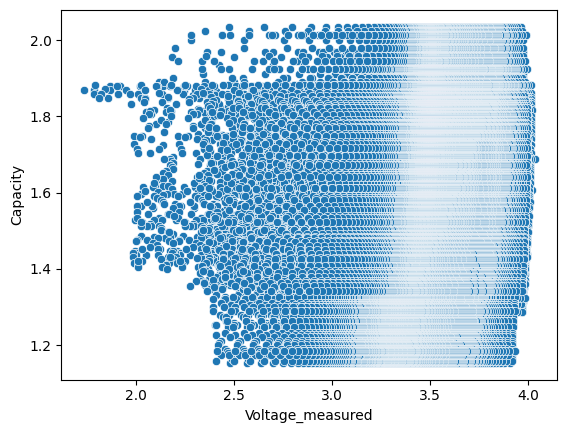

In [8]:
# Scatter plot of the voltage vs capacity variables
sns.scatterplot(data=data, x="Voltage_measured", y="Capacity")
plt.show()

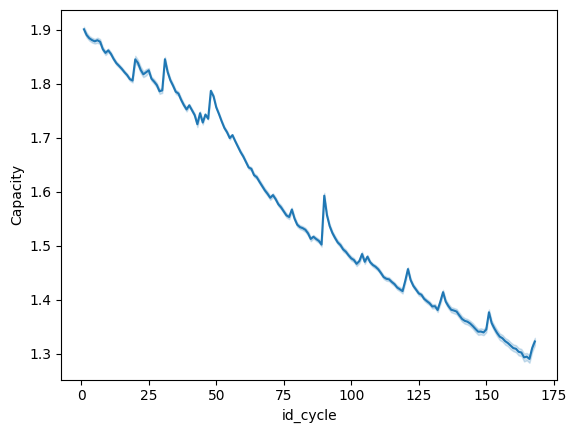

In [9]:
sns.lineplot(data=data, x="id_cycle", y="Capacity")
plt.show()

In [10]:
# Find the cycle with the highest average capacity
cycle_means = data.groupby('id_cycle')['Capacity'].mean()
max_cycle = cycle_means.idxmax()
print(f"The cycle with the highest average capacity is {max_cycle}")

The cycle with the highest average capacity is 1


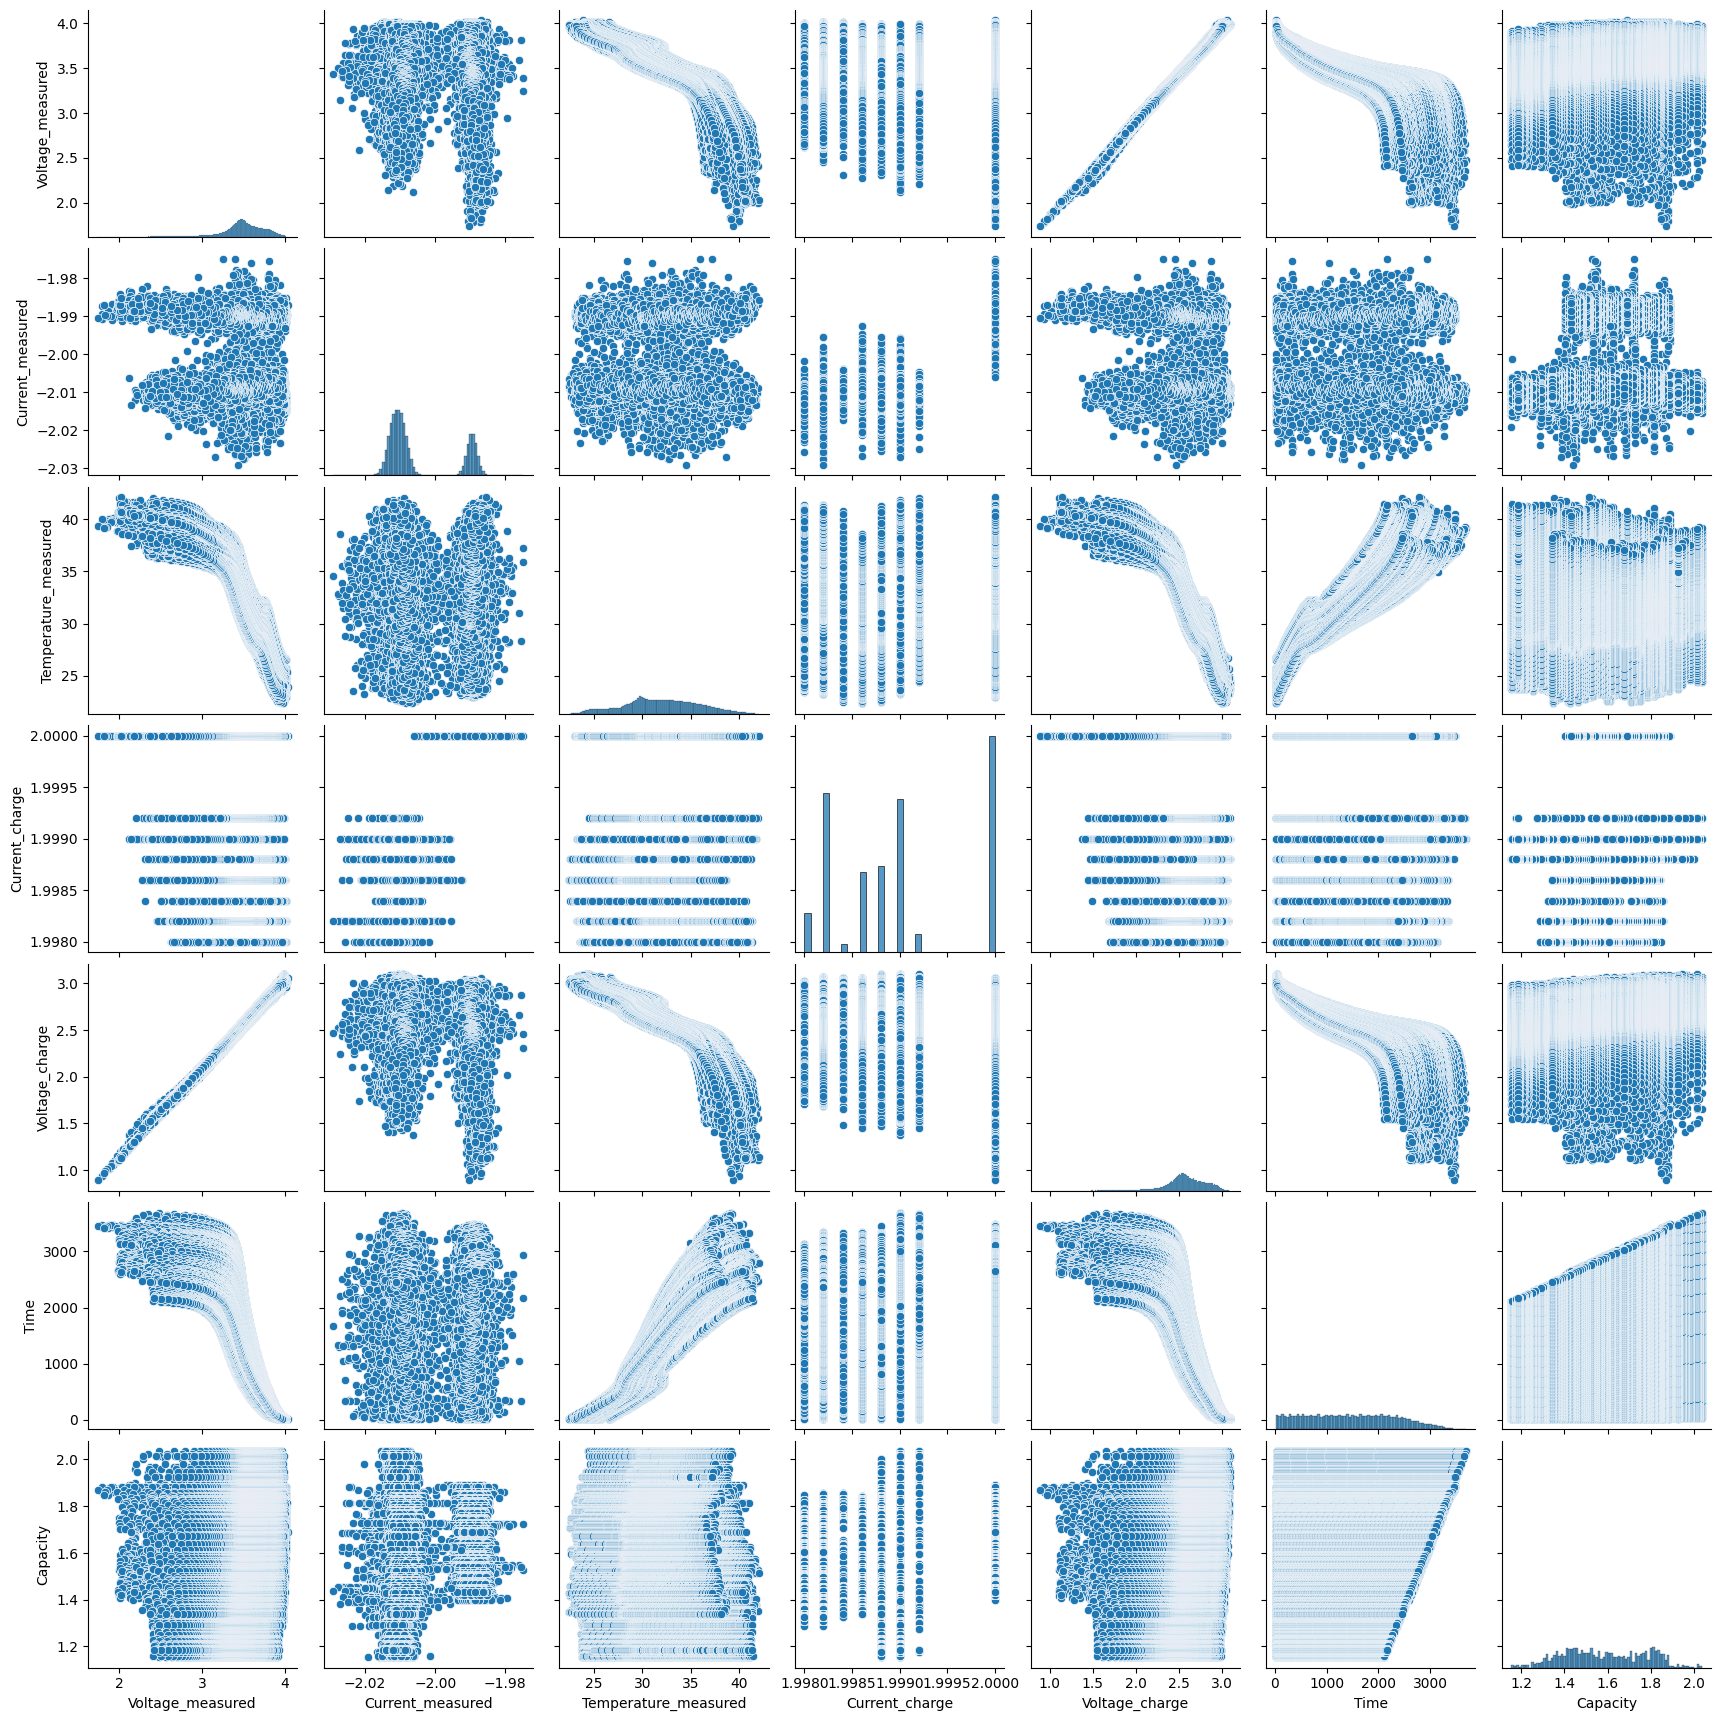

In [11]:
plot_features = ["Voltage_measured",	"Current_measured",	"Temperature_measured",	"Current_charge",	"Voltage_charge",	"Time",	"Capacity"]
sns.pairplot(data[plot_features])

In [12]:
data.head()

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time,Capacity,id_cycle,type,ambient_temperature,time,Battery
0,3.974871,-2.012528,24.389085,1.9982,3.062,35.703,1.856487,1,discharge,24,2008.0,B0005
1,3.951717,-2.013979,24.544752,1.9982,3.030,53.781,1.856487,1,discharge,24,2008.0,B0005
2,3.934352,-2.011144,24.731385,1.9982,3.011,71.922,1.856487,1,discharge,24,2008.0,B0005
3,3.920058,-2.013007,24.909816,1.9982,2.991,90.094,1.856487,1,discharge,24,2008.0,B0005
4,3.907904,-2.014400,25.105884,1.9982,2.977,108.281,1.856487,1,discharge,24,2008.0,B0005


In [13]:
features = ["id_cycle", "Temperature_measured", "Time", "Voltage_measured", "Current_measured", "Capacity"]
data = data[features]

# Split data into training and testing sets
split_ratio = 0.8
train_data, test_data = train_test_split(data, test_size=1-split_ratio)

# Train the Random Forest Regression model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(train_data[features[:-1]], train_data[features[-1]])

# Evaluate the model
y_pred = model.predict(test_data[features[:-1]])
mse = mean_squared_error(test_data[features[-1]], y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.0004500821969020425


<Axes: xlabel='Capacity'>

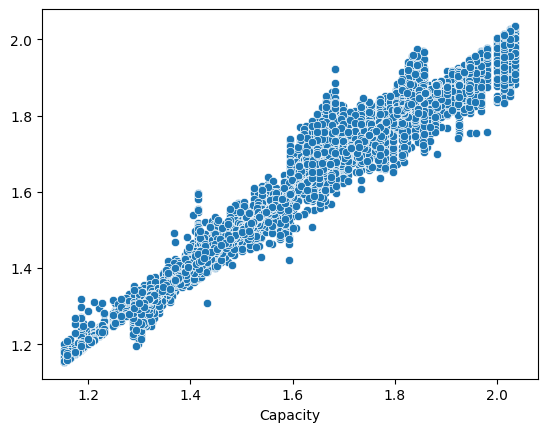

In [14]:
sns.scatterplot(x = test_data['Capacity'], y = y_pred)

In [15]:
r2 = r2_score(test_data[features[-1]], y_pred)
r2

0.9875349465352633

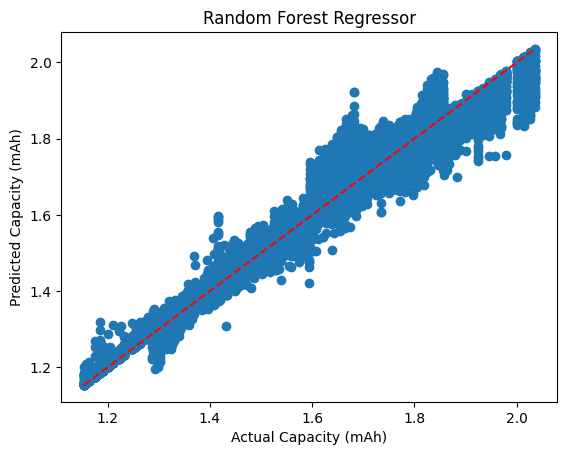

In [16]:
plt.scatter(test_data[features[-1]], y_pred)
plt.plot([test_data[features[-1]].min(), test_data[features[-1]].max()], [test_data[features[-1]].min(), test_data[features[-1]].max()], '--', color='red')
plt.xlabel("Actual Capacity (mAh)")
plt.ylabel("Predicted Capacity (mAh)")
plt.title("Random Forest Regressor")
plt.show()

In [27]:
# Load the data
data = pd.read_csv("discharge.csv")

# Extract relevant features
features = ["id_cycle", "Temperature_measured", "Time", "Voltage_measured", "Current_measured", "Capacity"]
data = data[features]

# Normalize the data
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# Create sequences
sequence_length = 50
X = []
y = []
for i in range(len(data) - sequence_length):
    X.append(data.iloc[i:i+sequence_length].values)
    y.append(data.iloc[i+sequence_length, -1])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))
X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

# Define the LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))

# Compile the model
model.compile(loss="mse", optimizer="adam")

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64)

# Evaluate the model
test_loss = model.evaluate(X_test, y_test, batch_size=64)
print("Test loss:", test_loss)


Epoch 1/5
2122/2122 [==============================] - 456s 211ms/step - loss: 5.3304e-04
Epoch 2/5
2122/2122 [==============================] - 449s 212ms/step - loss: 8.3298e-05
Epoch 3/5
2122/2122 [==============================] - 449s 211ms/step - loss: 4.6193e-05
Epoch 4/5
2122/2122 [==============================] - 451s 212ms/step - loss: 4.3033e-05
Epoch 5/5
531/531 [==============================] - 40s 74ms/step - loss: 1.2725e-05
Test loss: 1.2725275155389681e-05


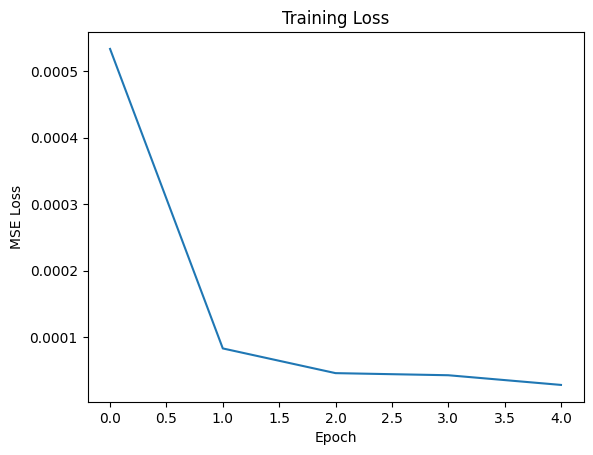

In [29]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('MSE Loss')
plt.xlabel('Epoch')
plt.show()

1061/1061 [==============================] - 54s 49ms/step


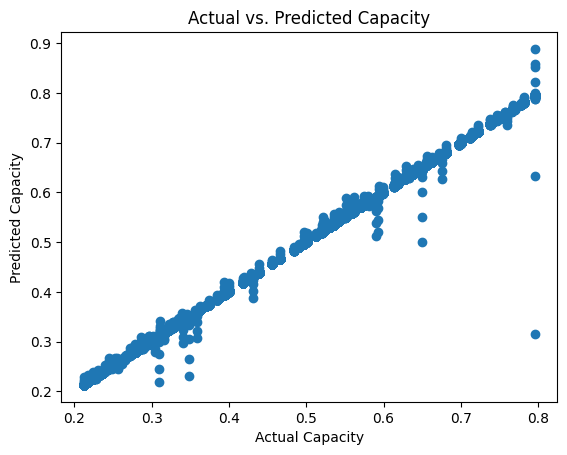

In [30]:
y_pred = model.predict(X_test)
plt.scatter(y_test, y_pred)
plt.title('Actual vs. Predicted Capacity')
plt.xlabel('Actual Capacity')
plt.ylabel('Predicted Capacity')
plt.show()